# GradCAM : Towards advanced Visual Explanations for CNNs

In recent years, Convolutional Neural Networks (CNNs) have revolutionized image analysis. With the emergence of these innovative techniques, we now can extract new insights and handle complex data such as images and videos more efficiently. They are becoming widely used in many industrial fields, with applications in medicine and automatic driving. Thus, their structural complexity, often seen as "black boxes", still makes Deep Learning networks such as CNNs hard to interpret.

More than ever, it becomes essential to be able to explain and interpret networks' behaviors. Industrials and researchers need to ensure that their algorithms are trustworthy and reliable. It is important to identify and to be able to justify the features that trigger a decision. The issue with CNNs is that usually, the more they are complex, the more accurate their results are, but also the more difficult they become to explain. They face a trade-off issue between accuracy and interpretability, which is an important field of research in this domain.

*How can we place trust in a model's decision if we cannot adequately explain what triggered the decision ?*

In 2019, R. Selvaraju et al. proposed a technique for producing **visual explanations** of large ranges of CNNs called **GradCAM** :


> " *Our approach – Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say‘dog’ in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting theimportant regions in the image for predicting the concept.* "

![VGG-16 architecture](/img/grad_cam_explanation.jpg?raw=true)


In other words, GradCAM highlights **where** the model is *looking* when making a decision, a classification. It is then be a really interesting tool to verify that a network has actually learned the right patterns or to understand why it is misclassifying.

GradCAM is designed to apply on many CNN-based models :

*   CNNs with fully connected layers ;
*   CNNs used for structured outputs (captioning) ;
*   CNNs used in tasks with multi-modal inputs.

In this notebook, we will explore and implement GradCAM step by step in order to finally apply it to some use-cases and practicle examples.

**SUMMARY**

1.  From CAM (Class Activation Mapping) to GradCAM

2. How does GradCAM work ? - Understanding decisions of a classification model

3. Guided GradCAM : High-resolution adn concept-specific visualizations
 3. a. Guided Backpropagation
 3. b. Guided GradCAM

4. GradCAM usecases : Diagnosing model classification and decision explanation


5. Conclusion

## I. From CAM (Class Activation Mapping) to GradCAM


4 years before GradCAM, **CAM (Class Activation Mapping)** technique was introduced in 2015 by Zhou *et al* in [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150) for visualizing the regions of an image that are important for the prediction made by a CNN model.

CAM generates class activation maps by computing a global average pooling (GAP) over the last convolutional layer followed by a weighted combination of these convolution maps.

![CAM technique](https://miro.medium.com/v2/resize:fit:1400/1*O5azF2X0KF1NQmpcooXF1Q.png)

Even if CAM proposed a new inovative way to analyze and explain behavior of CNNs, it still faced an important issue. Indeed, **CAM can only be applied to networks where global average pooled convolutional feature maps are fed directly into soft-max.**. Otherwise, it can be necessary to adapt and re-train the network to support the CAM technique. GradCAM proposes a generalization of CAM **to bigger range of CNNs based models, including those with fully-connected layers**.

*Note : We won't implement CAM in this notebook as it is not its main subject, but it is interesting to quickly go through the technique as GradCAM is directly based on it.*



## II. How does GradCAM work ? -  Understanding decisions of a classification model

In order to better illustrate and to implement step by step the GradCAM technique, we will visualize how it behaves on a well-known pre-trained model.

### Loading useful packages

In [81]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import models, datasets, transforms
import json
import requests
from io import BytesIO
import random
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

### Loading testing images
The following code loads some images that will be used as examples in the whole notebook.

In [82]:
# Photo of my cat
res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/my_cat.jpg?raw=true")
my_cat = Image.open(BytesIO(res.content))

# Cats and dogs
res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/cat_and_dog_1.jpg?raw=true")
cat_dog = Image.open(BytesIO(res.content))

res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/cat_and_dog_2.jpg?raw=true")
cat_dog2 = Image.open(BytesIO(res.content))

# Sheperds
res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/sheperd1.jpg?raw=true")
sheperd = Image.open(BytesIO(res.content))

res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/sheperd2.jpg?raw=true")
sheperd2 = Image.open(BytesIO(res.content))

# Golden Retrievers
res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/retriever.jpg?raw=true")
retriever = Image.open(BytesIO(res.content))

res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/retriever2.jpeg?raw=true")
retriever2 = Image.open(BytesIO(res.content))

# More dogs
res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/boxer.jpg?raw=true")
boxer = Image.open(BytesIO(res.content))

res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/australian.jpg?raw=true")
australian = Image.open(BytesIO(res.content))

res = requests.get("https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/husky.jpg?raw=true")
husky = Image.open(BytesIO(res.content))

For this first example, we will use this nice picture of my cat.


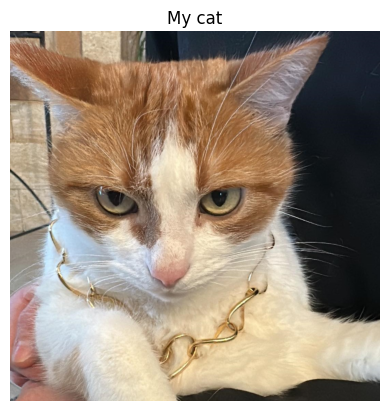

In [83]:
imgplot = plt.imshow(my_cat)
plt.axis('off')
plt.title(f'My cat')
plt.show()

### Loading a pre-trained model
We instantiate a model with pre-trained weights to avoid a costly and time-consuming re-training.

We chose the [Pytorch's VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.vgg16) model based on the [Very Deep Convolutional Networks for Large-Scale Image Recognition paper](https://arxiv.org/abs/1409.1556) and trained on the famous [ImageNet](https://www.image-net.org/) dataset.

**A few words about VGG ...**

VGG (Visual Geometry Group) is a convolutional neural network that achieved competitive performance. The VGG model investigates the depth of layers with a very small convolutional filter size (3 × 3) to deal with large-scale images. *16* stands for the layer lengths; VGG models are also available with 11 to 19 layer lengths (VGG11, VGG12.. VGG19).

It is important to have a look at the architecture of the model, as we will need it to implement GradCAM later.

![VGG-16 architecture](https://miro.medium.com/v2/resize:fit:1400/1*NNifzsJ7tD2kAfBXt3AzEg.png)


In [84]:
# Loading the model from Pytorch
model_vgg = models.vgg16(pretrained=True)
print(model_vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**... and ImageNet**

ImageNet is an image database designed for use in large-scale image recognition and computer vision research. Today (early February 2024), ImageNet contains more than 14 197 120 labeled web images over 1000 labels.

ILSVRC (ImageNet Large Scale Visual Recognition Challenge) is an annual famous competition that evaluate model's ability to correctly classify and/or locate on an image on the ImageNet dataset. In the 2014 edition, VGG-16 reached 92.7% of accuracy.

We load the class names corresponding to the **1000 labels** that the pre-trained Pytorch's VGG model is able to output.

In [85]:
# Load the ImageNet labels
labels = json.load(open('data/imagenet_class_index.json'))
labels = [labels[str(i)][1] for i in range(len(labels))]

# Print some classes examples
random_labels = random.sample(labels, 10)
print("Some random ImageNet labels:", random_labels)

Some random ImageNet labels: ['armadillo', 'garter_snake', 'pug', 'dumbbell', 'face_powder', 'stretcher', 'sleeping_bag', 'polecat', 'beacon', 'hyena']


### Test a prediction

Let's make sure that VGG-16 has been well loaded and works on my cat picture.

Before running the image through the model, we need to **pre-process** it to the format of the images with which VGG16 model was trained.

As we can read in the [documentation of VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.vgg16) available in PyTorch, the model was trained with ImageNet images resized in a square format of 224 x 224 pixels, rescaled to [0,1] and normalized with *mean=[0.48235, 0.45882, 0.40784], std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]* respectively on **R**ed, **G**reen and **B**lue channels. These normalizations corresponds to the mean and standard deviations of the ImageNet dataset.

In [86]:
# Loading Pytorch embedded VGG preprocessing
preprocessing = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

# Preprocessing my cat image
input_image = preprocessing(my_cat)
input_image = input_image.unsqueeze(0) # Add a singleton dimension to the tensor (batch size of 1 image)

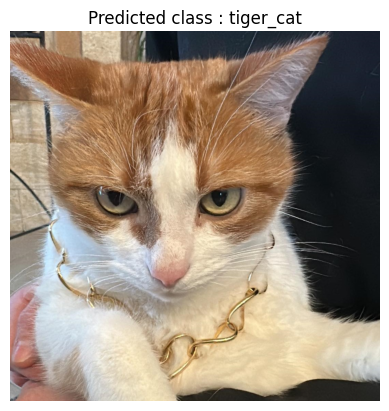

In [87]:
# Set the model to evaluation mode
model_vgg.eval()

# Prediction with the model
output = model_vgg(input_image)

# Get index of the predicted class
_, pred_idx = torch.max(output, 1)
predicted_class = labels[pred_idx.item()]

# Plot the image with the predicted class
imgplot = plt.imshow(my_cat)
plt.axis('off')  # Ne pas afficher les axes
plt.title(f'Predicted class : {predicted_class}')
plt.show()

The model has classified my image as a **tiger_cat**. It seems rather coherent. But how did it come to this decision ? This is where GradCAM comes in.



### Implementing GradCAM
GradCAM will help us highlight which parts of the image had the most impact on the final decision made by the model. Indeed, GradCAM builds a map that shows the important neurons for a particular decision, based on the gradient information in the last convolutional layer. Last convolutional layers would have the best trade-off between detailed spatial information and high-level semantics.

![GradCAM_explanation](https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/grad_cam_presentation.png?raw=true)

More specifically, this is how a GradCAM map is built :
1.   Compute the **gradients** ($\frac{\partial y^c}{\partial A^k}$) of the score for a given class *c* ($y^c$) before the *softmax* with respect to feature map activations $A^k$ of a convolutional layer.
2.   **Global-average-pool over width ($i$) and height ($j$)** dimensions to obtain the neuron importance weights $\alpha _k^c = \frac{1}{Z}\sum_{i}\sum_{i} \frac{\partial y^c}{\partial A^k_{ij}}$.
3. **Combine with weights of forward activation maps** and apply **ReLu** to the sum to obtain the final GradCAM map $L^{c}_{Grad-CAM}=ReLU(\sum_{k}\alpha _k^c A^k)$.

#### GradCAM on VGG16


To apply GradCAM on VGG16, we need to dissect the model to access the last convolutional layer gradients and activations maps.

```
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
```

Fortunately, PyTorch has a [*register_hook* method](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html) that registers gradient during a backward pass with respect to the Tensor to which it is applied. The idea is to attach this function to the Tensor corresponding to the last convolutional layer to be able to recall the gradients during the backward pass.

We implement a new customized VGG-16 PyTorch-based model that will be able to return the gradients and the activation map needed to compute GradCAM.



In [88]:
class GradVGG(nn.Module):
    def __init__(self):
        super(GradVGG, self).__init__()

        # Get the pre-trained Pytorch VGG16 model
        self.basevgg = models.vgg16(pretrained=True)

        # Crop the network til its last convolutional layer
        self.gradvgg_features = self.basevgg.features[:30]

        # Get the last MaxPool layer after the last convolutional layer
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # Get the model classifier
        self.classifier = self.basevgg.classifier

        # Gradients variable
        self.gradients = None

    # Hook function for the gradients
    def activations_hook(self, gradients):
        self.gradients = gradients

    def forward(self, x):

        x = self.gradvgg_features(x)

        # Register the gradients on the last convolutional layer
        h = x.register_hook(self.activations_hook)

        # Apply the remaining MaxPool function
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)

        return x

    # Function to get the last convolutional layer gradients
    def get_last_layer_gradients(self):
        return self.gradients

    # Function to get the last convolutional layer forward activation map
    def get_activation_map(self, x):
        return self.gradvgg_features(x)

Now, we have all the useful tools to apply GradCAM to our initial image !

#### Step 1 : Forward pass

In [89]:
# Instantiate a model
gradvgg_model = GradVGG()
gradvgg_model.eval()

# Predict the most probable label
prediction = gradvgg_model(input_image)

# Get the class index and name
output = torch.max(prediction, 1)
idx = output[1].item()
label = labels[idx]

print('The most probable class is '+label+' (index = '+str(idx)+').')

The most probable class is tiger_cat (index = 282).


#### Step 2 - Backward pass with respect to the predicted *tiger_cat* class

In [90]:
# Backward pass with respect to 'tiger_cat'
prediction[:, idx].backward()

#### Step 3 - Get $\frac{\partial y^{tigercat}}{\partial A^k}$ gradients of the last convolutional layer

In [91]:
gradients = gradvgg_model.get_last_layer_gradients()

#### Step 4 - Global average pooling over height and width to get $\alpha _k^{tigercat} = \frac{1}{Z}\sum_{i}\sum_{j} \frac{\partial y^{tigercat}}{\partial A^k_{ij}}$

In [92]:
gradients.shape

torch.Size([1, 512, 14, 14])

The output size is 14 x 14, which refers to the dimension 2 and 3 of the tensor. Dimension 0 si for the batch of size 0 (one single image is studied).

In [93]:
glob_avg_pool = torch.mean(gradients, dim = [0, 2, 3])

In [94]:
glob_avg_pool.shape

torch.Size([512])

#### Step 5 - Get the activation maps of the last convolutional layer $A^1 A^2$... $A^{512}$

In [95]:
acti_map = gradvgg_model.get_activation_map(input_image).detach()

#### Step 6 - Compute the final GradCAM map $L_{GradCAM}^{tigercat}$

 `grad_map` $ = \alpha_k^{tigercat}A^{k} $

In [96]:
grad_map = acti_map.clone()

# Combine weights of forward activation map
for i in range(acti_map.shape[1]):
        grad_map[:, i, :, :] *= glob_avg_pool[i]

 `grad_map` $ = \sum_{k} \alpha_k^{tigercat}A^{k} $

In [97]:
# Sum the combinations over all channels (dimension 1)
grad_map = grad_map.sum(dim=1).squeeze(0)

In [98]:
grad_map.shape

torch.Size([14, 14])

 `grad_map` $ = ReLU(\sum_{k} \alpha_k^{tigercat}A^{k}) $

In [99]:
# Apply ReLU
grad_map = nn.ReLU()(grad_map)

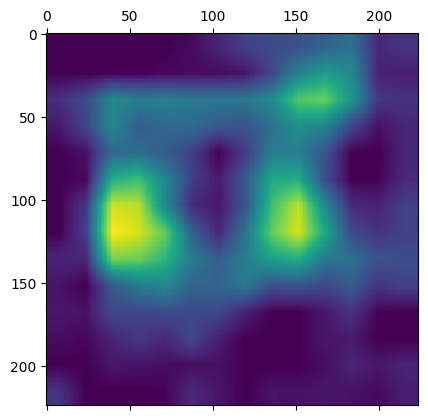

In [100]:
# Scaling the grad_map to be able to rescale to RGB channels
grad_map /= torch.max(grad_map)

# Resize GradCAM map from 14 x 14 to input image size 224 x 224
grad_map = cv2.resize(grad_map.numpy(), (224,224 ))

plt.matshow(grad_map)

#### Step 7 - Visualize result

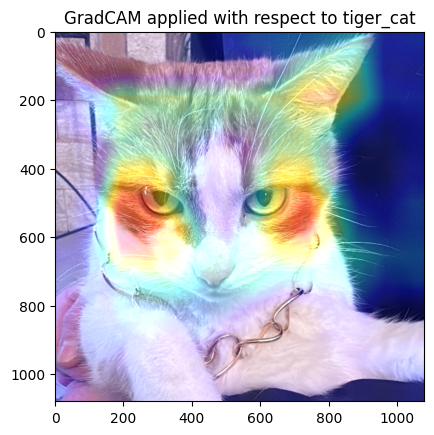

In [101]:
# Convert PIL image to numpy array
numpy_array = np.array(my_cat)

# Convert RGB to BGR (OpenCV uses BGR by default)
img = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2BGR)
heatmap = cv2.resize(grad_map, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Put the GradMAP over the original image
superimposed_img = heatmap * 0.4 + img

# Conversions
superimposed_convert = cv2.cvtColor(cv2.convertScaleAbs(superimposed_img), cv2.COLOR_BGR2RGB)
superimposed_PIL = Image.fromarray(superimposed_convert)

# Displaying the final result
plt.imshow(superimposed_PIL)
plt.title('GradCAM applied with respect to '+str(labels[idx]))
plt.show()

It seems that my cat has been classified as a *tiger cat* because of its whiskers, its ears and the stripes on its cheeks. Rather consistent doesn't it ? It feels like the pre-trained VGG 16 model relied on coherent patterns to predict the *tiger_cat* ImageNet class.

In order to use this model and to apply GradCAM more easily in the rest of the notebook, we wrap all the previous cells into some functions.

In [102]:
# Pre-processing the image to pass it through the model
def preprocess_to_predict(image):
    """
    This function preprocess an image for prediction.

    Parameters:
    image (PIL Image): Image to preprocess.

    Returns:
    Tensor: Pre-processed image in tensor format.
    """

    # Loading Pytorch embedded VGG preprocessing
    preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Preprocessing my cat image
    input_image = preprocessing(image)
    input_image = input_image.unsqueeze(0) # Add a singleton dimension to the tensor (batch size of 1 image)

    return input_image


def load_model(name):
    """
    This function loads a model.

    Parameters:
    name (str): Reference of the model to load. 'vgg16' for PyTorch VGG, 'gradvgg' for implemented VGG16 GradCAM model.

    Returns:
    Model: Model in evaluation mode
    """

    if name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.eval()

    if name == 'gradvgg':
        model = GradVGG()
        model.eval()

    return model

def display_predictions(image, model, k):
    """
    This function displays an image and its classification with respect to a model.

    Parameters:
    image (PIL Image): Image to predict.
    model (Model): A model in evaluation mode.
    k (int): Top k predictions to output.

    """

    # Pre-process the image into the format compatible with the model
    input_image = preprocess_to_predict(image)

    # Predict with model
    output = model(input_image)

    # Get the top K class predictions
    topk_prob, topk_idx = torch.topk(output, k)
    topk_labels = [labels[i.item()] for i in topk_idx[0]]

    # Plot the image
    imgplot = plt.imshow(image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f'Predicted class : {topk_labels[0]}')
    plt.show()
    print("### Top "+str(k)+" class predictions ###")
    print(topk_labels)
    print("### Top "+str(k)+" class probabilities ###")
    print(topk_prob)
    print("### Top "+str(k)+" class classes ###")
    print(topk_idx[0])

def apply_gradcam(model, image, size=224, label=None, out=False):
    """
    Apply GradCAM on a pre-trained model and a given image.

    Parameters:
    image (PIL Image): PIL Image to apply GradCAM on.
    size (int): Size of the heatmap.
    label (str): Class for the GradCAM technique.
    output (bool): Return the heatmap or not.
    """
    model.eval()

    # Predict the class of the image with the model
    input_image = preprocess_to_predict(image)
    pred = model(input_image)

    if label == None:
        # Get the most likely class
        class_index = torch.max(pred,1)[1].item()

    if label == 'cat':
        class_index = 282 # index of class "tiger_cat" in ImageNet

    # Backward pass with respect to class_index
    pred[0][class_index].backward()

    # Gradients of the last convolutional layer
    gradients = model.get_last_layer_gradients()

    # Global average pooling over gradients
    glob_avg_pool = torch.mean(gradients, dim = [0, 2, 3])

    # Get the activation map of the last convolutional layer
    acti_map = model.get_activation_map(input_image).detach()

    grad_map = acti_map.clone()

    # Combine weights of forward activation map
    for i in range(acti_map.shape[1]):
        grad_map[:, i, :, :] *= glob_avg_pool[i]

    # Sum the combinations over all channels (dimension 1)
    grad_map = grad_map.sum(dim=1).squeeze(0)

    # Apply ReLU
    grad_map = nn.ReLU()(grad_map)

    # Scaling the grad_map to be able to apply to RGB channels (superposing)
    grad_map /= torch.max(grad_map)

    if not out: # Plot visualization only

        # Convert PIL image to numpy array
        numpy_array = np.array(image)

        # Convert RGB to BGR (OpenCV uses BGR by default)
        img = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2BGR)

        # Resize to the image size
        map = cv2.resize(grad_map.numpy(), (img.shape[1], img.shape[0]))

        # Apply to create a gradient over 255
        map = np.uint8(255 * map)
        map = cv2.applyColorMap(map, cv2.COLORMAP_JET)

        # Combine the map with the original image
        superimposed_cv2 = map * 0.4 + img
        superimposed_convert = cv2.cvtColor(cv2.convertScaleAbs(superimposed_cv2), cv2.COLOR_BGR2RGB)

        # Displaying the final result
        superimposed_PIL = Image.fromarray(superimposed_convert)
        plt.imshow(superimposed_PIL)
        plt.title('GradCAM applied with respect to '+str(labels[class_index]))
        plt.show()

    if out: # Return map only

        # Resize GradCAM map from 14 x 14 to input image size 224 x 224
        map = cv2.resize(grad_map.numpy(), (224,224 ), interpolation = cv2.INTER_LINEAR)

        # Apply to create a gradient over 255
        map = np.uint8(map*255)
        map = cv2.applyColorMap(map, cv2.COLORMAP_JET)
        return cv2.cvtColor(cv2.convertScaleAbs(map), cv2.COLOR_BGR2RGB)

## III. Guided GradCAM : High-resolution and concept-specific visualizations

While GradCAM effectively localizes relevant image regions for classification, it lacks fine-grained detail. As we have seen in the previous example, GradCAM successfully localized and identified the cat, but we are not sure about the reasons that led specifically to *tiger_cat*. To gain in fine detail, one technique is to multiply the heatmap generated by GradCAM with a **guided backpropagation** map. This is known as the **Guided GradCAM** technique.

![Guided GradCAM](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*Ymoztp-krf0wWPE1)

### III.1. Guided Backpropagation

Similarly to GradCAM, Guided Backpropagation is a method to produce visual explanation to show which inputs were used to make a prediction in a neural network. It is a combination of two other techniques : simple backpropagation (Vanilla) and DeconvNet method.

It is based on the principle that we want to **neglect negative gradients** by setting them to zero (by applying a ReLU during the backward pass) and to **focus only on the positive inputs**.

![Guided_backprop 1](https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/guided_backprop.png?raw=true)

![Guided_backprop 2](https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/guided_backprop2.png?raw=true)

The following Guided Backpropagation implementation has been implemented in [this notebook](https://leslietj.github.io/2020/07/22/Deep-Learning-Guided-BackPropagation/) by Leslie Tang. If you are interested in the subject, I add some comments.



In [103]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model.eval()

        # Final image map
        self.image_reconstruction = None

        # List of activation maps to store during forward pass
        self.activation_maps = []

        # Similarly to GradCAM, we need to save activation maps and gradients
        self.register_hooks()

    def register_hooks(self):

        # Reconstruct the final image map
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.image_reconstruction = grad_in[0]

        # Save the activation maps F1, ... FL
        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        # Modify the gradients during backpropagation
        def backward_hook_fn(module, grad_in, grad_out):

            # Starting from the back, taking the last activation map
            grad = self.activation_maps.pop()

            # If the gradients are positive, set the value to 1, otherwise set to 0.
            grad[grad > 0] = 1

            # grad_out[0] stores the gradients for each feature map,
            # Keep only the positive gradients
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad

            return (new_grad_in,)


        # List of the CNN model layers
        modules = list(self.model.features.named_children())

        # Going through all the layers, registering hooks for ReLU
        for name, module in modules:

            # If the layer is a ReLU
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        # Register backward hook for the first layer
        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

    def compute_map(self, input_image, target_class):

        # Forward pass, make the prediction
        model_output = self.model(input_image)

        # Get the most probable class
        pred_class = model_output.argmax().item()

        self.model.zero_grad()

        # Create a list of the final gradient map
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)

        # Set to 1 the target class for backpropagation
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1

        # Backward pass
        model_output.backward(grad_target_map)

        result = self.image_reconstruction.data[0].permute(1,2,0)

        return self.normalize(result.numpy()), pred_class


    def normalize(self, image):
        norm = (image - image.mean())/image.std()
        norm = norm * 0.1
        norm = norm + 0.5
        norm = norm.clip(0, 1)
        return norm

def apply_backprop(model, image, size=224, label=None, out=False):
    """
    Compute Guided backpropagation map for a given image and model.

    Parameters:
    image (PIL Image): PIL Image to apply GradCAM on.
    size (int): Size of the heatmap.
    label (str): Class for the GradCAM technique.
    out (bool): Return the map or not.
    """

    input_image = preprocess_to_predict(image)

    input_image = input_image.requires_grad_()

    guided_bp = GuidedBackprop(model)
    result, pred_class = guided_bp.compute_map(input_image, None)

    if not out: # Plot only the visualization
        plt.title('Guided Backpropagation with respect to : '+labels[pred_class])
        plt.imshow(result)
        plt.show()

    if out: # Output the final map
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        return result, pred_class

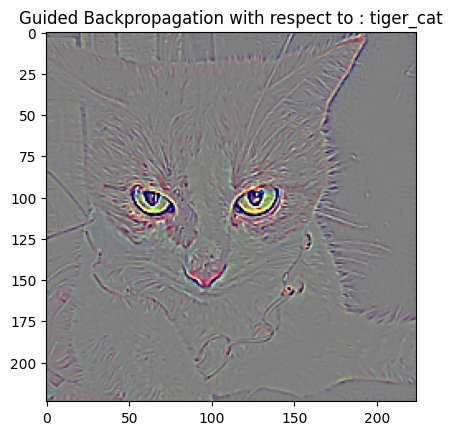

In [104]:
apply_backprop(model_vgg, my_cat)

### III.2. Guided GradCAM

Now that we have computed the guided backpropagation, we can combine it with the GradCAM map computed in the previous steps.

> " *In order to combine the best aspects of both, we fuse
Guided Backpropagation and Grad-CAM visualizations via
element-wise multiplication (*[GradCAM heatmap] *is first upsampled to the input image resolution using bilinear interpolation).* "

![Guided_backprop 1](https://github.com/valmjnrv/GradCAM_SDD_2024/blob/main/img/guided_gradcam.PNG?raw=true)

Note: With this simple indication, I didn't achieve to get a greyscale map as in the original article. It is possible that the combination is a bit more complex.



In [105]:
def apply_guided_gradcam(image, size=224, label=None):
    """
    Apply Guided GradCAM for VGG16.

    Parameters:
    image (PIL): Image to apply Guided GradCAM on.
    size (int): Size of the heatmap.
    label (str): Class for the GradCAM technique.
    """

    # Extract the GradCAM heatmap
    gradmap = apply_gradcam(gradvgg_model, image, size, label, out=True)

    # Extract the Guided Backpropagation heatmap
    guided, pred_class = apply_backprop(model_vgg, image, size, label, out=True)

    # Compute the guided GradCAM result
    guided_gradcam = (gradmap * guided)
    guided_gradcam = cv2.cvtColor(cv2.convertScaleAbs(guided_gradcam), cv2.COLOR_BGR2RGB)

    # Displaying the final result
    guided_gradcam = Image.fromarray(guided_gradcam)
    plt.imshow(guided_gradcam)
    plt.title('Guided GradCAM applied with respect to '+str(labels[pred_class]))
    plt.show()

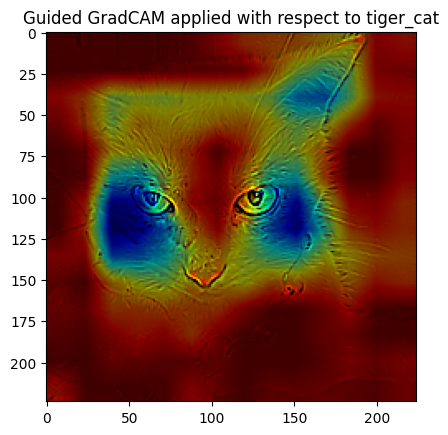

In [106]:
apply_guided_gradcam(my_cat)

Thanks to the combination of Guided Backpropagation and GradCAM, we are able to visualize even more detailed patterns in the original image that led to *tiger_cat* classification. There is no doubt about the detection of the stripes on the cat's cheeks (you can increase your laptop brightness if needed ;) ). Beyond the stripes, the  cat's eyes and fur seems really important for the model to make its decision. Guided GradCAM increased the level of finesse of the analysis of input patterns that influenced the model choice.

## IV. GradCAM usecases : Diagnosing model classification and decision explanation

Now that we are more familiar with GradCAM, we can move on to some applications.

We used VGG to predict the class of a simple image where only one dominant class was represented. As VGG-16 is a classification model, it is able to predict only one class.

*What happens if we pass it more images where different classes are present ? How to interpret its classification ?*

For instance, let's take simple images of cats and dogs. As both pets are almost equally represented, the image label is not obvious.


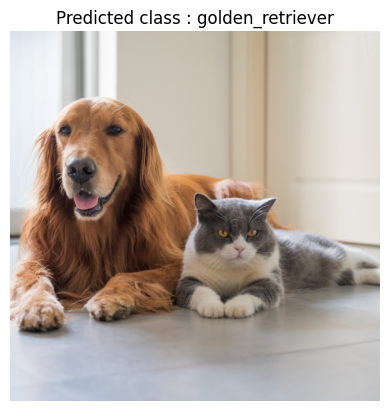

### Top 5 class predictions ###
['golden_retriever', 'tennis_ball', 'tub', 'bathtub', 'doormat']
### Top 5 class probabilities ###
tensor([[7.2642, 6.7194, 6.2802, 5.7351, 5.5533]], grad_fn=<TopkBackward0>)
### Top 5 class classes ###
tensor([207, 852, 876, 435, 539])


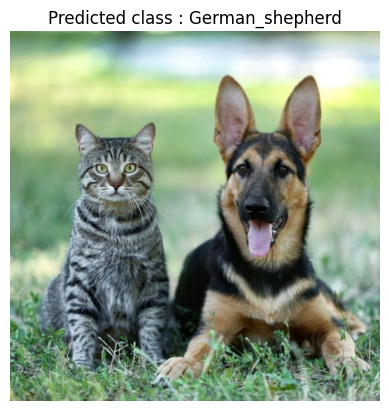

### Top 5 class predictions ###
['German_shepherd', 'kelpie', 'malinois', 'soccer_ball', 'Cardigan']
### Top 5 class probabilities ###
tensor([[13.7626,  9.9072,  9.6682,  7.9898,  7.9877]],
       grad_fn=<TopkBackward0>)
### Top 5 class classes ###
tensor([235, 227, 225, 805, 264])


In [107]:
# Display and predict the class of two images with a cat and a dog
display_predictions(cat_dog, model_vgg, 5)
display_predictions(cat_dog2, model_vgg, 5)

Both images have been classified as *dog* and the cat has been ignored : it is not even in the top 5 predicted classes !

Let's visualize the GradCAM map of *golden_retriever* and *German_sheperd*.

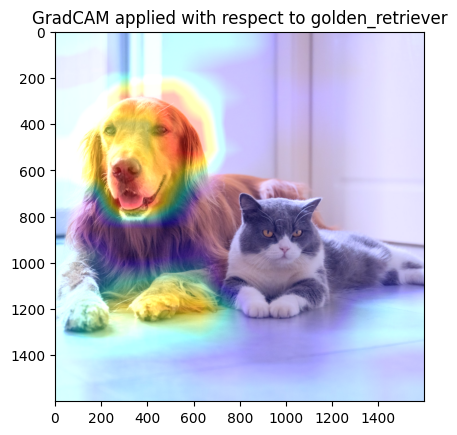

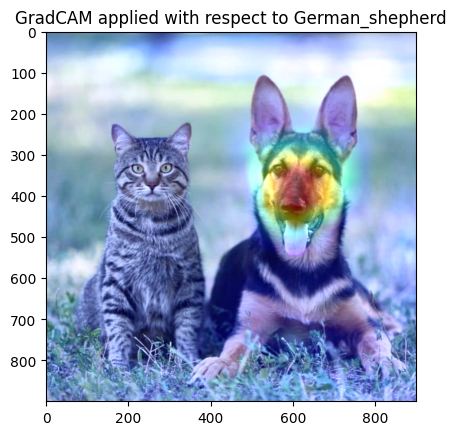

In [108]:
apply_gradcam(gradvgg_model, cat_dog, size=224)
apply_gradcam(gradvgg_model, cat_dog2, size=224)

There is no doubt about it : the model has well identified the two dog breeds. But a cat is also on the both images. Was it completely ignored by the model ? Let's try to re-apply GradCAM on these two images, but now with respect to the *cat* output label.


In [109]:
# Output 282 corresponds to the tiger cat ImageNet class
labels[282]

'tiger_cat'

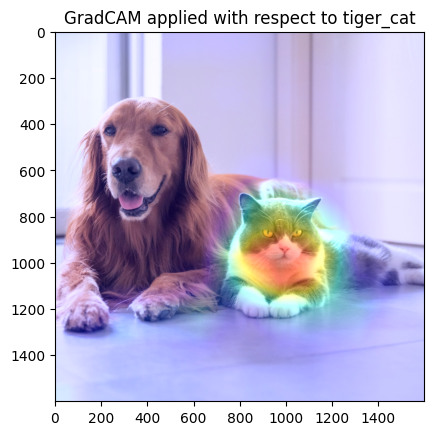

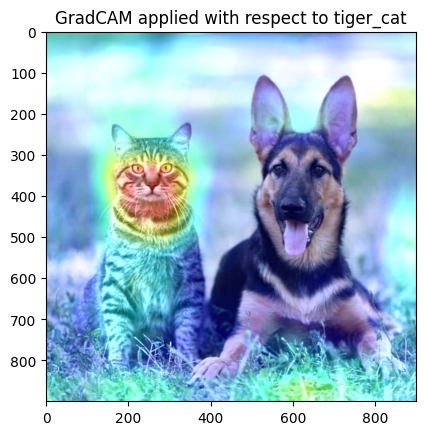

In [110]:
# Optional parameter 'label' was implemented to force to backpropagate on a given class
apply_gradcam(gradvgg_model, cat_dog, size=224, label='cat')
apply_gradcam(gradvgg_model, cat_dog2, size=224, label='cat')

Even if the final image classification didn't lead to a cat,  the GradCAM heatmap computed with respect to *tiger_cat* shows that both were well detected ! It proves the model consistency in recognizing cats, as only cats are highlighted by GradCAM for this class.



What is also interesting is that the model has focused on the shepherd's distinctive mouth and not really the rest of its body. Additionaly, Retriever's GradCAM map also highlights its paws and hair.

Let's see how the model behaves when classifying different dog breeds.

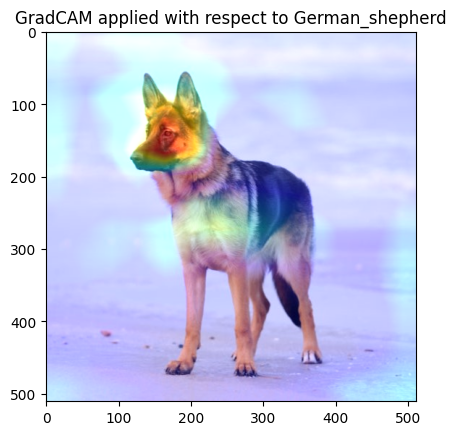

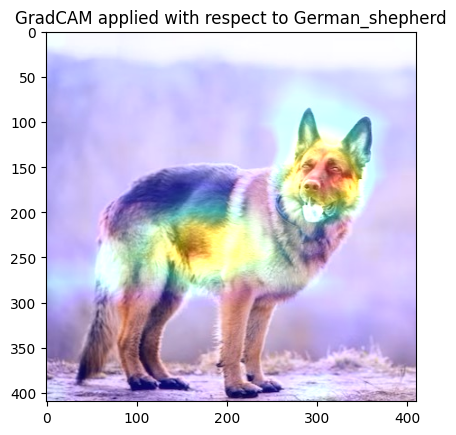

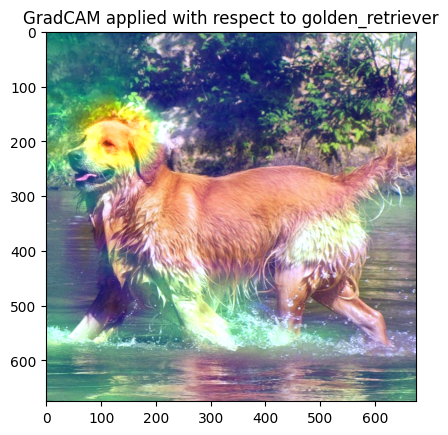

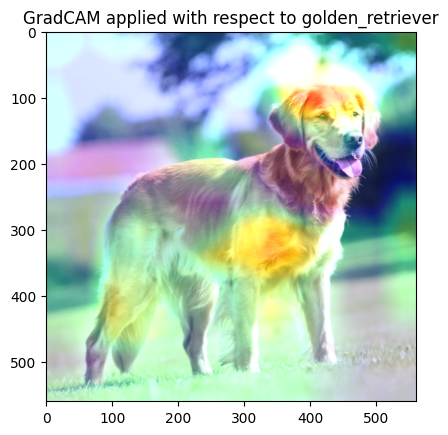

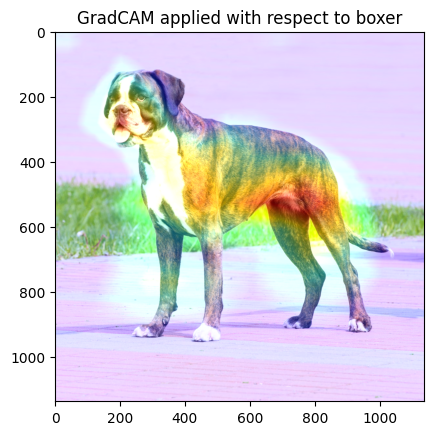

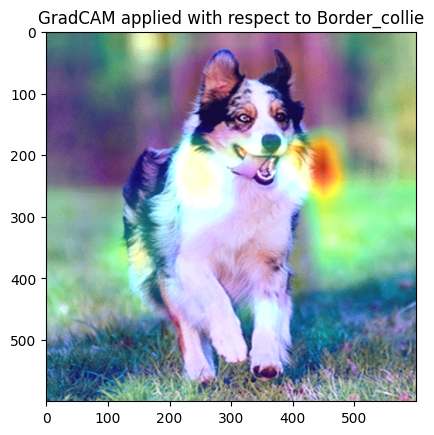

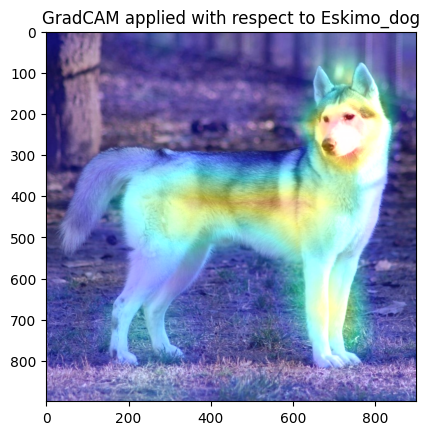

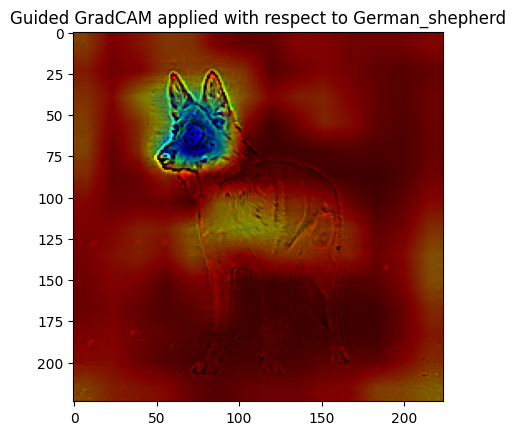

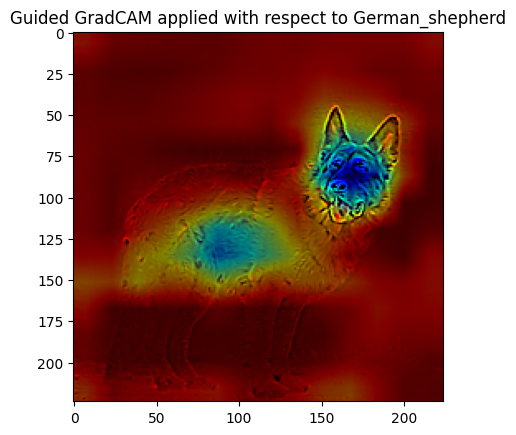

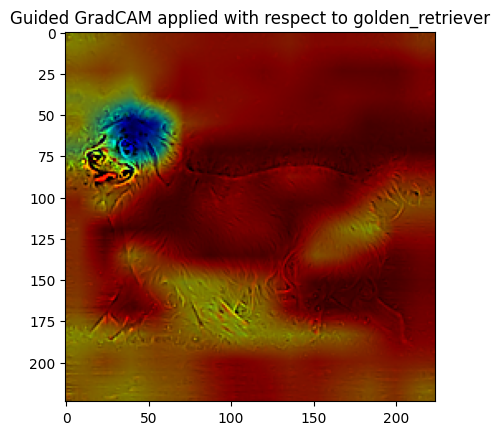

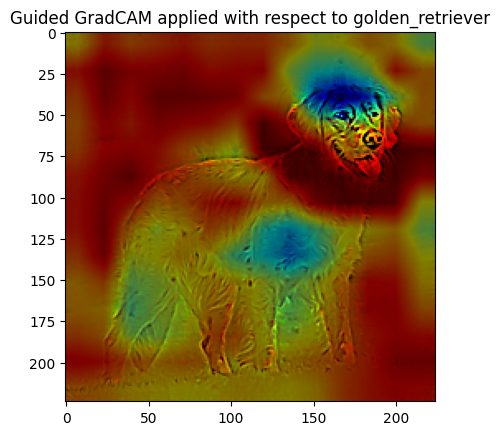

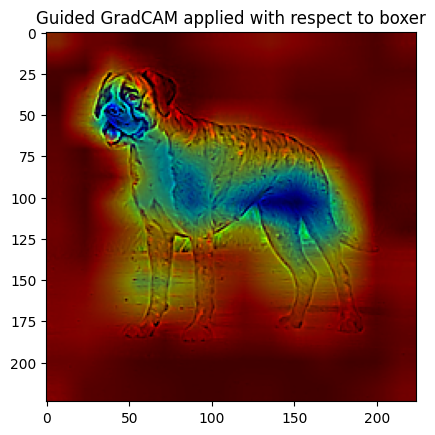

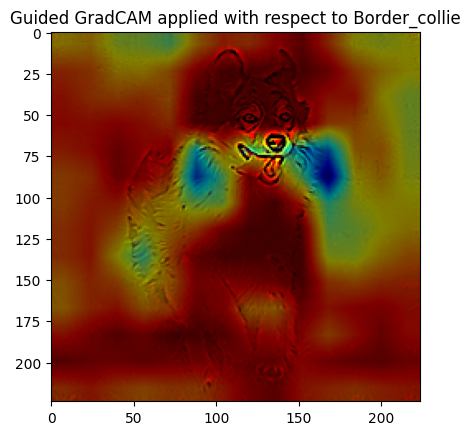

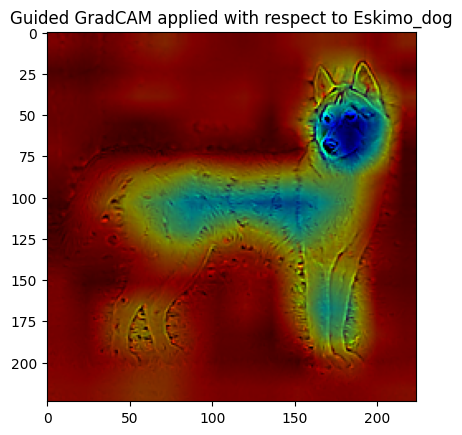

In [112]:
# Apply GradCAM
apply_gradcam(gradvgg_model, sheperd, size=224)
apply_gradcam(gradvgg_model, sheperd2, size=224)
apply_gradcam(gradvgg_model, retriever, size=224)
apply_gradcam(gradvgg_model, retriever2, size=224)
apply_gradcam(gradvgg_model, boxer, size=224)
apply_gradcam(gradvgg_model, australian, size=224)
apply_gradcam(gradvgg_model, husky, size=224)

# Apply GuidedGradCAM
apply_guided_gradcam(sheperd, size=224)
apply_guided_gradcam(sheperd2, size=224)
apply_guided_gradcam(retriever, size=224)
apply_guided_gradcam(retriever2, size=224)
apply_guided_gradcam(boxer, size=224)
apply_guided_gradcam(australian, size=224)
apply_guided_gradcam(husky, size=224)

Each breed is detected by its main features :


*   Golden Retriever and German Sheperd's heads and a bit of fur ;
*   The typical Boxer face and body ;
*   The Border Collie's bushy cheek hairs ;
*   The Husky's distinctive white and grey coat.

This is quite reassuring as the characteristic of a breed are clearly highlighted and deterministic to the final decision. The model seems to have learned consistently.

Finally, GradCAM is really useful to be able to **justify the decisions of a model**. We can simply image how it can be relevant for industrials to be able to assess their algorithm fiability and to use them with confidence.

## V. Conclusions

In this notebook, we have focus on the application of GradCAM on VGG-16 and image classification only. Recall it is possible to implement it on other types of CNNs, but also on image captioning and VQA (Visual Question Answering) algorithms.

![field_of_application](https://miro.medium.com/v2/resize:fit:3376/1*HuiYnh0iRLogVNl2AAKJtA.png)

In general, this technique can be applied in various domains, including medical imaging and autonomous vehicles, to improve model performance, enhance trust in AI systems, and facilitate collaboration between AI algorithms and human experts. GradCAM helps users understand why a particular decision was made, enabling them **to validate model predictions and refine algorithms for real-world applications**. Its interpretability makes GradCAM a valuable tool for both researchers and practitioners striving to develop more accurate, transparent, and trustworthy deep learning models.

## References
Some of the most useful articles and websites I used to write this notebook.

[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

[Deep Learning with PyTorch : GradCAM](https://www.coursera.org/projects/deep-learning-with-pytorch-gradcam)

[GradCAM – Enhancing Neural Network Interpretability in the Realm of Explainable AI](https://learnopencv.com/intro-to-gradcam/)

[Deep Learning: Guided Backpropagation](https://leslietj.github.io/2020/07/22/Deep-Learning-Guided-BackPropagation/)

[CNN Heat Maps: Gradients vs. DeconvNets vs. Guided Backpropagation](https://glassboxmedicine.com/2019/10/06/cnn-heat-maps-gradients-vs-deconvnets-vs-guided-backpropagation/ )

[Generalized way of Interpreting CNNs using Guided Gradient Class Activation Maps!!](https://medium.com/@chinesh4/generalized-way-of-interpreting-cnns-a7d1b0178709)

